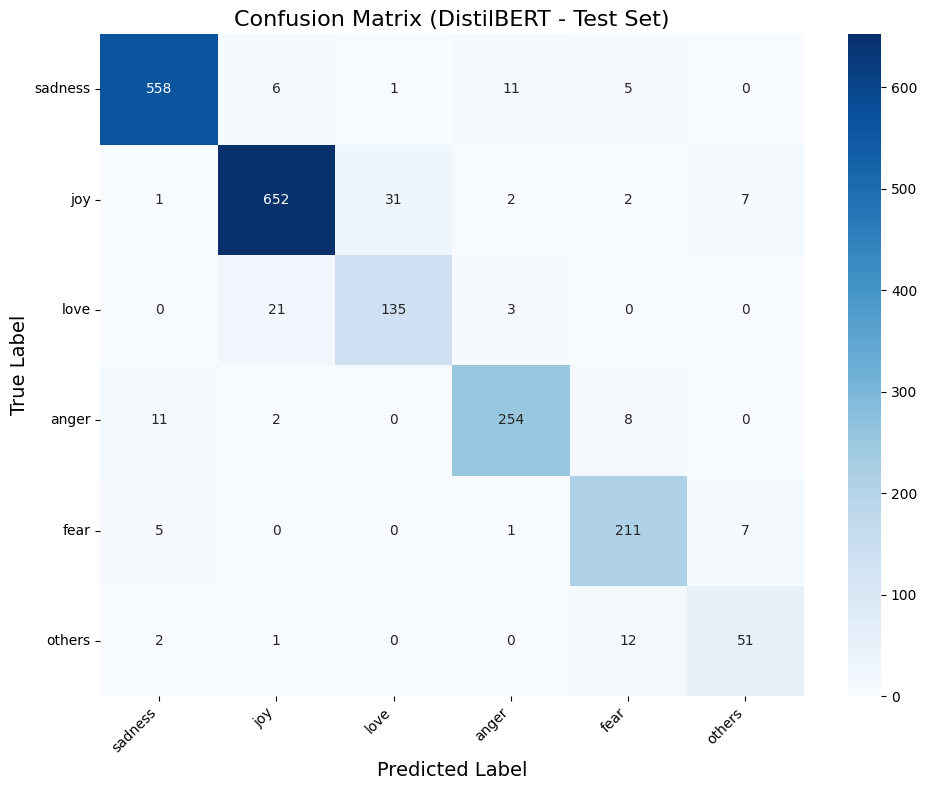

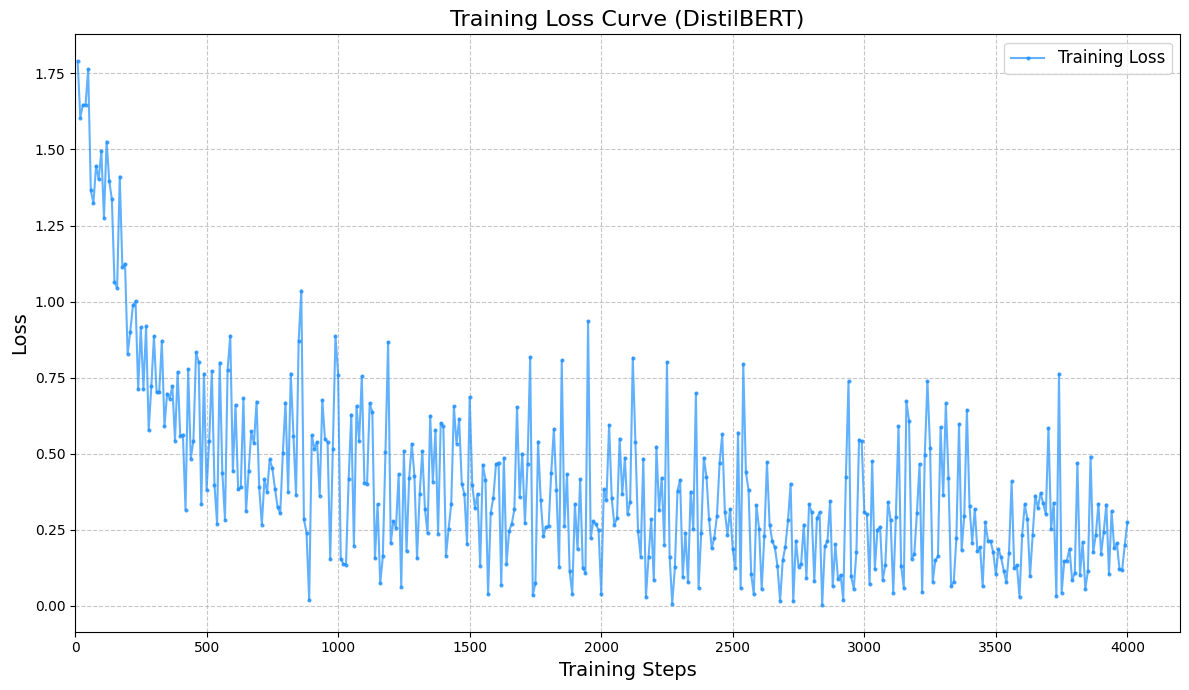

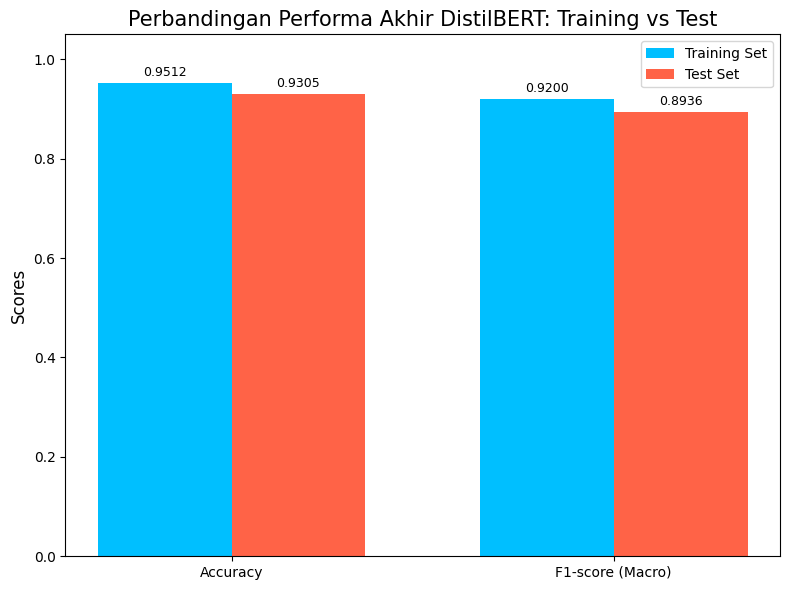

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import json
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

# 1. Konfigurasi Awal & Definisi
label_map = {
    0: "sadness", 1: "joy", 2: "love",
    3: "anger", 4: "fear", 5: "others"
}
sorted_label_keys = sorted(label_map.keys())
sorted_label_names = [label_map[k] for k in sorted_label_keys]

PATH_TO_DISTILBERT_TRAINER_STATE = "E:/Semester 4/TWS/results/checkpoint-4000/trainer_state.json"
INPUT_CSV_RESULTS_TEST = "E:/Semester 4/TWS/distilbert_predictions_actual_vs_pred.csv"

FINAL_TRAIN_ACCURACY = 0.9512
FINAL_TRAIN_F1_MACRO = 0.92

# 2. Memuat Hasil Inferensi pada TEST SET & Menghitung Metrik Test
df_results_test = pd.read_csv(INPUT_CSV_RESULTS_TEST)
y_true_test_distilbert = np.array(df_results_test['y_true'].tolist())
y_pred_test_distilbert = np.array(df_results_test['y_pred'].tolist())

report_test_dict = classification_report(y_true_test_distilbert, y_pred_test_distilbert, labels=sorted_label_keys, output_dict=True, zero_division=0)
test_set_accuracy = report_test_dict.get('accuracy')
test_set_f1_macro = report_test_dict.get('macro avg', {}).get('f1-score')

# 3. Fungsi-Fungsi Plotting
def plot_distilbert_confusion_matrix(y_true, y_pred, class_labels_map_func):
    local_sorted_label_keys = sorted(class_labels_map_func.keys())
    display_labels = [class_labels_map_func.get(lbl, str(lbl)) for lbl in sorted(list(set(np.concatenate((np.unique(y_true), np.unique(y_pred))))))]

    cm = confusion_matrix(y_true, y_pred, labels=local_sorted_label_keys)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=display_labels, 
                yticklabels=display_labels)
    plt.title('Confusion Matrix (DistilBERT - Test Set)', fontsize=16)
    plt.ylabel('True Label', fontsize=14); plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0); plt.tight_layout()
    plt.show(); plt.close()

def plot_distilbert_loss_curve(log_history_func):
    train_loss_steps = []
    train_loss_values = []
    max_step = 0
    for log_entry in log_history_func:
        current_step = log_entry.get('step')
        if current_step is not None: max_step = max(max_step, current_step)
        if 'loss' in log_entry and 'step' in log_entry:
            train_loss_steps.append(log_entry['step']); train_loss_values.append(log_entry['loss'])
            
    plt.figure(figsize=(12, 7))
    sorted_train_data = sorted(zip(train_loss_steps, train_loss_values))
    train_steps_sorted, train_values_sorted = zip(*sorted_train_data)
    plt.plot(train_steps_sorted, train_values_sorted, label='Training Loss', marker='.', linestyle='-', alpha=0.7, markersize=4, color='dodgerblue')
    plt.title('Training Loss Curve (DistilBERT)', fontsize=16)
    plt.xlabel('Training Steps', fontsize=14); plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12); plt.grid(True, linestyle='--', alpha=0.7)
    if max_step > 0: plt.xlim(0, max_step + int(max_step*0.05) )
    plt.tight_layout(); plt.show(); plt.close()

def plot_final_metrics_comparison_distilbert(train_acc_func, test_acc_func, train_f1_func, test_f1_func):
    labels = ['Accuracy', 'F1-score (Macro)']
    train_metrics = [train_acc_func, train_f1_func]
    test_metrics = [test_acc_func, test_f1_func]
    x = np.arange(len(labels)); width = 0.35
    fig, ax = plt.subplots(figsize=(8,6))
    rects1 = ax.bar(x - width/2, train_metrics, width, label='Training Set', color='deepskyblue')
    rects2 = ax.bar(x + width/2, test_metrics, width, label='Test Set', color='tomato')
    ax.set_ylabel('Scores', fontsize=12); ax.set_title('Perbandingan Performa Akhir DistilBERT: Training vs Test', fontsize=15)
    ax.set_xticks(x); ax.set_xticklabels(labels, fontsize=10); ax.legend(fontsize=10); ax.set_ylim(0, max(1.05, max(train_metrics + test_metrics) * 1.1) )
    def autolabel(rects_func):
        for rect in rects_func:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}', xy=(rect.get_x()+rect.get_width()/2, height), xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
    autolabel(rects1); autolabel(rects2)
    plt.tight_layout(); plt.show(); plt.close()

# 4. Memuat Log History DistilBERT
with open(PATH_TO_DISTILBERT_TRAINER_STATE, 'r') as f:
    trainer_state = json.load(f)
log_history_distilbert = trainer_state.get("log_history")

# 5. Panggil Fungsi Plotting Utama
plot_distilbert_confusion_matrix(y_true_test_distilbert, y_pred_test_distilbert, label_map)
plot_distilbert_loss_curve(log_history_distilbert)
plot_final_metrics_comparison_distilbert(
    FINAL_TRAIN_ACCURACY, test_set_accuracy,
    FINAL_TRAIN_F1_MACRO, test_set_f1_macro
)

## Load Visualisasi ke MLFlow

In [ ]:
import mlflow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import json
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

# 1. Konfigurasi Awal & Definisi
label_map = {
    0: "sadness", 1: "joy", 2: "love",
    3: "anger", 4: "fear", 5: "others"
}
sorted_label_keys = sorted(label_map.keys())
sorted_label_names = [label_map[k] for k in sorted_label_keys]

PATH_TO_DISTILBERT_TRAINER_STATE = "E:/Semester 4/TWS/results/checkpoint-4000/trainer_state.json" 
INPUT_CSV_RESULTS_TEST = "E:/Semester 4/TWS/distilbert_predictions_actual_vs_pred.csv"

# Konfigurasi MLflow Tracking
mlflow.set_tracking_uri("file:///E:/Semester 4/TWS/mlruns")

FINAL_TRAIN_ACCURACY = 0.9512
FINAL_TRAIN_F1_MACRO = 0.92

# 2. Memuat Hasil Inferensi pada TEST SET & Menghitung Metrik Test
df_results_test = pd.read_csv(INPUT_CSV_RESULTS_TEST)
y_true_test_distilbert = np.array(df_results_test['y_true'].tolist())
y_pred_test_distilbert = np.array(df_results_test['y_pred'].tolist())

report_test_dict = classification_report(y_true_test_distilbert, y_pred_test_distilbert, labels=sorted_label_keys, output_dict=True, zero_division=0)
test_set_accuracy = report_test_dict.get('accuracy')
test_set_f1_macro = report_test_dict.get('macro avg', {}).get('f1-score')


# 3. Fungsi-Fungsi Plotting
def plot_distilbert_confusion_matrix(y_true, y_pred, class_labels_map_func):
    local_sorted_label_keys = sorted(class_labels_map_func.keys())
    display_labels = [class_labels_map_func.get(lbl, str(lbl)) for lbl in sorted(list(set(np.concatenate((np.unique(y_true), np.unique(y_pred))))))]

    cm = confusion_matrix(y_true, y_pred, labels=local_sorted_label_keys)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=display_labels, 
                yticklabels=display_labels)
    plt.title('Confusion Matrix (DistilBERT - Test Set)', fontsize=16)
    plt.ylabel('True Label', fontsize=14); plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0); plt.tight_layout()

def plot_distilbert_loss_curve(log_history_func):
    train_loss_steps = []
    train_loss_values = []
    max_step = 0
    for log_entry in log_history_func:
        current_step = log_entry.get('step')
        if current_step is not None: max_step = max(max_step, current_step)
        if 'loss' in log_entry and 'step' in log_entry:
            train_loss_steps.append(log_entry['step']); train_loss_values.append(log_entry['loss'])
            
    plt.figure(figsize=(12, 7))
    sorted_train_data = sorted(zip(train_loss_steps, train_loss_values))
    train_steps_sorted, train_values_sorted = zip(*sorted_train_data)
    plt.plot(train_steps_sorted, train_values_sorted, label='Training Loss', marker='.', linestyle='-', alpha=0.7, markersize=4, color='dodgerblue')
    plt.title('Training Loss Curve (DistilBERT)', fontsize=16)
    plt.xlabel('Training Steps', fontsize=14); plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12); plt.grid(True, linestyle='--', alpha=0.7)
    if max_step > 0: plt.xlim(0, max_step + int(max_step*0.05) )
    plt.tight_layout()

def plot_final_metrics_comparison_distilbert(train_acc_func, test_acc_func, train_f1_func, test_f1_func):
    labels = ['Accuracy', 'F1-score (Macro)']
    train_metrics = [train_acc_func, train_f1_func]
    test_metrics = [test_acc_func, test_f1_func]
    x = np.arange(len(labels)); width = 0.35
    fig, ax = plt.subplots(figsize=(8,6))
    rects1 = ax.bar(x - width/2, train_metrics, width, label='Training Set', color='deepskyblue')
    rects2 = ax.bar(x + width/2, test_metrics, width, label='Test Set', color='tomato')
    ax.set_ylabel('Scores', fontsize=12); ax.set_title('Perbandingan Performa Akhir DistilBERT: Training vs Test', fontsize=15)
    ax.set_xticks(x); ax.set_xticklabels(labels, fontsize=10); ax.legend(fontsize=10); ax.set_ylim(0, max(1.05, max(train_metrics + test_metrics) * 1.1) )
    def autolabel(rects_func): 
        for rect in rects_func:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}', xy=(rect.get_x()+rect.get_width()/2, height), xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
    autolabel(rects1); autolabel(rects2)
    plt.tight_layout()


# 4. Memuat Log History DistilBERT
with open(PATH_TO_DISTILBERT_TRAINER_STATE, 'r') as f:
    trainer_state = json.load(f)
log_history_distilbert = trainer_state.get("log_history")

TARGET_RUN_ID = "aaf843e0ccd141a3952629446462daaa"

print(f"Menambahkan visualisasi ke MLflow Run ID: {TARGET_RUN_ID}")

try:
    with mlflow.start_run(run_id=TARGET_RUN_ID) as run:
        print(f"Berhasil menyambung ke MLflow Run: {run.info.run_id}")
        
        # Log parameter visualisasi yang relevan
        mlflow.log_param("visualized_train_accuracy", FINAL_TRAIN_ACCURACY)
        mlflow.log_param("visualized_train_f1_macro", FINAL_TRAIN_F1_MACRO)
        mlflow.log_param("visualized_test_accuracy", test_set_accuracy)
        mlflow.log_param("visualized_test_f1_macro", test_set_f1_macro)

        # Melog Confusion Matrix
        plot_distilbert_confusion_matrix(y_true_test_distilbert, y_pred_test_distilbert, label_map)
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()

        # Melog Training Loss Curve
        plot_distilbert_loss_curve(log_history_distilbert)
        plt.savefig("training_loss_curve.png")
        mlflow.log_artifact("training_loss_curve.png")
        plt.close()

        # Melog Plot Perbandingan Akhir Training vs Test
        plot_final_metrics_comparison_distilbert(
            FINAL_TRAIN_ACCURACY, test_set_accuracy,
            FINAL_TRAIN_F1_MACRO, test_set_f1_macro
        )
        plt.savefig("final_metrics_comparison.png")
        mlflow.log_artifact("final_metrics_comparison.png")
        plt.close()

except Exception as e:
    print(f"ERROR: Gagal melog visualisasi ke MLflow: {e}")
    print("Pastikan MLflow server Anda berjalan dan TARGET_RUN_ID sudah benar.")